# Bigram text analysis 

- Raw data: Each line of Star Wars episodes 1-6 from Jean Wieme (see [this Github repo](https://github.com/jcwieme/data-scripts-star-wars)). 
- Cleaned data: See [this notebook](https://github.com/Lisa-Ho/small-data-projects/blob/main/2023/2308-star-wars-scripts/star-wars-scripts.ipynb) for the data cleaning process. 
- Followed [this tutorial](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/) for the bigram analysis (co-occurence of words)


Assets:
- [SF Distant Galaxy Font](https://www.fontspace.com/sf-distant-galaxy-font-f6436)
- Image of 3-CPO ([Star Wars fandom](https://starwars.fandom.com/zh/wiki/C-3PO))

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk import bigrams
import itertools
import collections
import networkx as nx

## Load data

Import cleaned data that contains text from episodes 1-6.

In [2]:
# load data
df = pd.read_csv("star-wars-episodes-1-6-all_text.csv")

In [3]:
# print columns
df.columns

Index(['id', 'from', 'to', 'text', 'text to check', 'where', 'number', 'nouns',
       'determiners', 'conjuctions', 'adjectives', 'prepositions', 'pronouns',
       'verbs', 'adverbs', 'undefined', 'time', 'episode'],
      dtype='object')

In [4]:
print("Unique characters:", df["from"].nunique())
print("Lines of C-3PO:", len(df[df["from"].str.find("THREEPIO") !=-1]))

Unique characters: 267
Lines of C-3PO: 319


## Data prep

We need to clean the text frist so that we can do some proper analysis. This includes

- Standardising
- Removing stop words

For bigram analysis, left out tokenizing and lemmatizing. 

In [5]:
# filter text for C-3PO
df_filtered = df[df["from"].str.find("THREEPIO") !=-1].reset_index(drop=True)

### Standardising

In [6]:
# make text lower case
text = df_filtered["text"].str.lower()

# replace values within titles

# function to loop through the column and replace substrings
def replace_values(text, dic):
    for x, y in dic.items():
        text = text.str.replace(x, y, regex=True)
    return text

# list of values to be replaced, including punctuation
replace_dict = {"&amp;": " ", #xml syntax for &
                "\n":" ",
                "[!\"#$%&()*+,./:;<=>?@[\]^_`{|}~“”-]": " ",
                "  ": " ", #double space
                "see threepio": "c-3po",
                "c 3po": "c-3po",
                "artoo":"r2",
                "r2 d2": "r2-d2"
               }
                
# apply function
text = replace_values(text, replace_dict)

# strip white space at the end
text = text.str.strip()

# add new column to dataframe
df_filtered["text_standardised"] = text

print(text)

0      how do you do i am c-3po human cyborg relation...
1             i'm not sure this floor is entirely stable
2          hello i don't believe we have been introduced
3      r2-d2 a pleasure to meet you i am c-3po human ...
4          i beg your pardon but what do you mean  naked
                             ...                        
314                                          oh r2 hurry
315       my goodness r2 why did you have to be so brave
316                   oh princess leia are you all right
317                                              oh dear
318                                          they did it
Name: text, Length: 319, dtype: object


### Remove stop words

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lisa.hornung\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
# create empty list to store text without stop words
text_no_stop_words = []

# iterate through each word in each text row and append those that are no stop words
# split titles into substrings using space as delimiter
for words in text.str.split(" "):
    x = []
    try:
        for word in words:
            if word not in stop_words:
                x.append(word)
    
    #exception for missing data
    except TypeError:
        x.append(" ")
    text_no_stop_words.append(x)

# join titles back together
text_no_stop_words = [" ".join(items) for items in text_no_stop_words]

# add title to dataframe
df_filtered["text_no_stop_words"] = text_no_stop_words

print(text_no_stop_words[:3])

['c-3po human cyborg relations might serve', "i'm sure floor entirely stable", 'hello believe introduced']


## Analyse

In [10]:
# split words per lines
text_no_stop_words_split = [i.split() for i in text_no_stop_words]

# Create list of lists containing bigrams in lines
terms_bigram = [list(bigrams(words)) for words in text_no_stop_words_split]

# View bigrams for the first line
terms_bigram[0]

[('c-3po', 'human'),
 ('human', 'cyborg'),
 ('cyborg', 'relations'),
 ('relations', 'might'),
 ('might', 'serve')]

In [11]:
# Flatten list of bigrams in clean tweets
bigrams_flat = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams_flat)

In [12]:
bigram_df = pd.DataFrame(bigram_counts.most_common(25),
                             columns=['bigram', 'count'])

new_df = {"bigram": [], "count":[]}
for i, bigram in enumerate(bigram_df["bigram"]):
    if bigram[0] != bigram[1]:
        new_df["bigram"].append(bigram)
        new_df["count"].append(bigram_df["count"][i])

bigram_df = pd.DataFrame.from_dict(new_df)
bigram_df

,bigram,count
0,"(master, luke)",21
1,"(oh, dear)",9
2,"(i'm, afraid)",7
3,"(princess, leia)",7
4,"(come, back)",6
5,"(c-3po, human)",5
6,"(human, cyborg)",4
7,"(cyborg, relations)",4
8,"(i'm, sure)",4
9,"(we're, doomed)",4


In [ ]:
# TODO: get counts of individuals words to weight nodes

## Data viz

- weight edges ([Post](https://stackoverflow.com/questions/25639169/networkx-change-color-width-according-to-edge-attributes-inconsistent-result))

In [13]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(np.log(v)**2))

# get series of weights for graph
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

In [151]:
# TODO: weight nodes (ie. size of markers) based on total occurence
nodes = G.nodes()
nodes

NodeView(('master', 'luke', 'oh', 'dear', "i'm", 'afraid', 'princess', 'leia', 'come', 'back', 'c-3po', 'human', 'cyborg', 'relations', 'sure', "we're", 'doomed', 'excuse', 'sir', 'r2', 'unit', 'might', 'captain', 'solo', 'terribly', 'jabba', 'hutt', 'beg', 'pardon', 'quite', 'right', 'going', 'way'))

In [14]:
from matplotlib import font_manager
#font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\SfDistantGalaxyOutline-xoeO.ttf')
subtitle_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\SfDistantGalaxy-0l3d.ttf')

# set custom font
plt.rcParams["font.family"] = ["Ubuntu"]

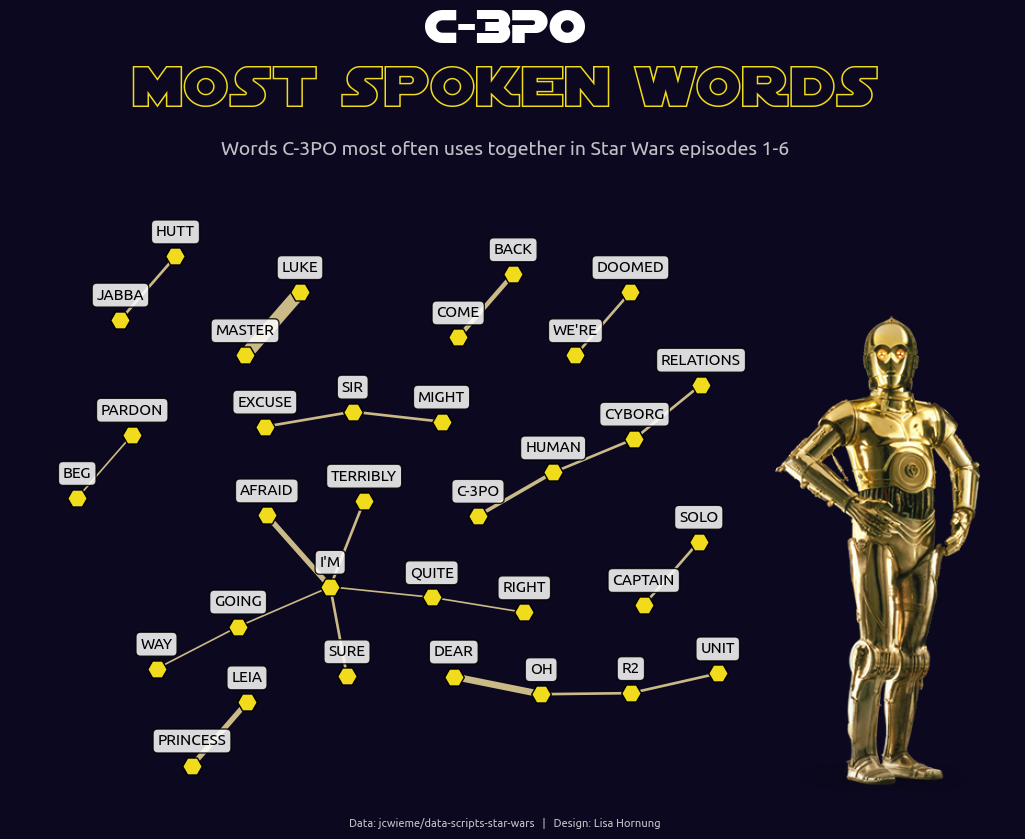

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot networks
pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
nx.draw_networkx(G, pos,
                 width=weights,
                 node_size=200,
                 edge_color='#CABA88',
                 node_color='#F0DB1D',
                 edgecolors="black",
                 node_shape="H",
                 with_labels = False,
                 ax=ax)

# Offset labels
for key, value in pos.items():
    x, y = value[0], value[1]+22
    ax.text(x, y,
            s=key.upper(),
            bbox=dict(facecolor='white', alpha=0.85, ec="black", boxstyle="round", pad=0.3),
            ha='center', va="center", fontsize=11, linespacing=0)

# style
fig.set_facecolor("#0C081F")
ax.axis("off")

# place image
imax = fig.add_axes([.88, -.05, .25, .99])
image = plt.imread("C-3PO-image.png")
imax.imshow(image)
imax.axis("off")

# title + footer
plt.figtext(0.62,1.08, "C-3PO", fontproperties = subtitle_font, fontsize=36, color="white", ha="center")
plt.figtext(0.62,1.0, "Most spoken Words", fontproperties = title_font, fontsize=44, color="#F0DB1D", ha="center")
plt.figtext(0.62, 0.94, "Words C-3PO most often uses together in Star Wars episodes 1-6",  fontsize=14, color="white", ha="center", alpha=0.75)
plt.figtext(0.62,0.1, "Data: jcwieme/data-scripts-star-wars   |   Design: Lisa Hornung", fontsize=8, color="white", ha="center", alpha=0.75)

plt.savefig("c-3po-most-spoken-words-v2.png", bbox_inches='tight', dpi=120, pad_inches=1)

plt.show()